<a href="https://colab.research.google.com/github/alessandronicolini/IotHomeworks/blob/main/HW2/IoT_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset
import argparse
import numpy as np
import os
import pandas as pd

# metric class
from keras.metrics import Metric

# model
from keras.models import Model
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dense
from keras.layers import Flatten, Input, Concatenate
import tensorflow as tf
from keras.optimizers import Adam
from keras.losses import mse

##Dataset

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True,
    cache_dir='.', cache_subdir='data')
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

column_indices = [2, 5]
columns = df.columns[column_indices]
data = df[columns].values.astype(np.float32)

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

input_width = 6
LABEL_OPTIONS = 6 #args.labels


class WindowGenerator:
    def __init__(self, input_width, label_options, mean, std):
        self.input_width = input_width
        self.label_options = label_options
        self.mean = tf.reshape(tf.convert_to_tensor(mean), [1, 1, 2])
        self.std = tf.reshape(tf.convert_to_tensor(std), [1, 1, 2])

    def split_window(self, features):
        inputs = features[:, :-6, :]
        labels= features[:, -6:, :]
        num_labels = 6

        inputs.set_shape([None, self.input_width, 2])
        labels.set_shape([None, num_labels, 2])

        return inputs, labels

    def normalize(self, features):
        features = (features - self.mean) / (self.std + 1.e-6)

        return features

    def preprocess(self, features):
        inputs, labels = self.split_window(features)
        inputs = self.normalize(inputs)

        return inputs, labels

    def make_dataset(self, data, train):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=input_width+6,
                sequence_stride=1,
                batch_size=32) 
        
        ds = ds.map(self.preprocess)
        ds = ds.cache()
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds


generator = WindowGenerator(input_width, LABEL_OPTIONS, mean, std)
train_ds = generator.make_dataset(train_data, True)
val_ds = generator.make_dataset(val_data, False)
test_ds = generator.make_dataset(test_data, False)


##Metric classes

In [50]:
# METRIC CLASS

class MaeTemp(Metric):
  def __init__(self, name="mae_T", **kwargs):
    super().__init__(name, **kwargs)
    self.total = self.add_weight('total', initializer='zeros') # accumulate the total error
    self.count = self.add_weight('count', initializer='zeros') # accumulate the number of elements 

  def reset_state(self):
    self.count.assign(tf.zero_like(self.count))
    self.total.assign(tf.zero_like(self.total))

    return

  def update_state(self, y_true, y_pred, sample_weight=None):
    # compute on how many elements you evaluate the error
    n_elements = 32*y_pred.shape[1] # 32*6
    
    # evaluate the error and accumulate first across batch elements and then 
    # across columns to get the total error related to temperature and humidity
    error = tf.abs(y_pred[:,:,0] - y_true[:,:,0]) # shape=[32, 6, 1] CONSIDER THE TEMPERATURE DATA
    error  = tf.reduce_sum(error, axis=0) # shape=[6,1]
    error = tf.reduce_sum(error, axis=0) # shape=[1]

    # update state variables
    self.total.assign_add(error)
    self.count.assign_add(n_elements)

    return
  
  def result(self):
    result = tf.math.divide_no_nan(self.total, self.count)

    return result


class MaeHum(Metric):
  def __init__(self, name="mae_H", **kwargs):
    super().__init__(name, **kwargs)
    self.total = self.add_weight('total', initializer='zeros') # accumulate the total error
    self.count = self.add_weight('count', initializer='zeros') # accumulate the number of elements 

  def reset_state(self):
    self.count.assign(tf.zero_like(self.count))
    self.total.assign(tf.zero_like(self.total))

    return

  def update_state(self, y_true, y_pred, sample_weight=None):
    # compute on how many elements you evaluate the error
    n_elements = 32*y_pred.shape[1]# 32*6
    
    # evaluate the error and accumulate first across batche elements and then 
    # across columns to get the total error related to temperature and humidity
    error = tf.abs(y_pred[:,:,1] - y_true[:,:,1]) # shape=[32, 6, 1] CONSIDER THE HUMIDITY DATA
    error  = tf.reduce_sum(error, axis=0) # shape=[6,1]
    error = tf.reduce_sum(error, axis=0) # shape=[1]

    # update state variables
    self.total.assign_add(error)
    self.count.assign_add(n_elements)

    return

  def result(self):
    result = tf.math.divide_no_nan(self.total, self.count)

    return result


##CNN model with 12 outupts nodes

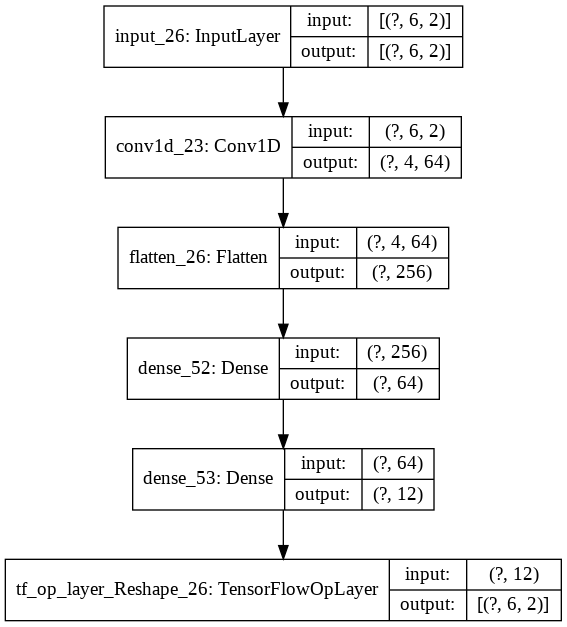

In [53]:
n_outputs = 12

# define the model
inputs = Input(shape=(6,2))
x = Conv1D(filters=64, kernel_size=3, activation="relu")(inputs)
x = Flatten()(x)
x = Dense(units=64, activation="relu")(x)
x = Dense(units=n_outputs)(x)
model = Model(inputs=inputs, outputs=tf.reshape(x,[-1,6,2]))

# print the model
plot_model(model, 'cnn.png', show_shapes=True)

In [54]:
# compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=mse,
              metrics=[MaeTemp(), MaeHum()])

# fit model
model.fit(train_ds, batch_size=32, epochs=10, validation_data=val_ds)

# test the model
results = model.evaluate(test_ds, batch_size=32)

Epoch 1/10
9200/9200 [==============================] - 17s 2ms/step - loss: 380.8254 - mae_T: 4.0980 - mae_H: 16.3501 - val_loss: 17.7342 - val_mae_T: 2.5313 - val_mae_H: 3.6263
Epoch 2/10
9200/9200 [==============================] - 16s 2ms/step - loss: 9.5948 - mae_T: 1.0304 - mae_H: 2.7801 - val_loss: 6.5865 - val_mae_T: 0.7704 - val_mae_H: 2.2552
Epoch 3/10
9200/9200 [==============================] - 16s 2ms/step - loss: 6.0583 - mae_T: 0.7447 - mae_H: 2.1433 - val_loss: 5.3605 - val_mae_T: 0.6549 - val_mae_H: 1.9587
Epoch 4/10
9200/9200 [==============================] - 16s 2ms/step - loss: 5.2675 - mae_T: 0.6234 - mae_H: 1.9864 - val_loss: 5.0647 - val_mae_T: 0.5783 - val_mae_H: 1.9331
Epoch 5/10
9200/9200 [==============================] - 18s 2ms/step - loss: 4.9327 - mae_T: 0.5472 - mae_H: 1.9181 - val_loss: 4.7860 - val_mae_T: 0.5267 - val_mae_H: 1.8171
Epoch 6/10
9200/9200 [==============================] - 16s 2ms/step - loss: 4.7311 - mae_T: 0.5168 - mae_H: 1.8725 - val